This script performs trajectory predicton the PETS-S2L1 dataset. 

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from pylab import *
from scipy. ndimage import filters
import pandas as pd
import os
from keras.models import Model, Sequential, save_model, load_model
import math
from sklearn.metrics import mean_squared_error

import random
from sklearn.preprocessing import MinMaxScaler
import h5py
import tensorflow as tf


Using TensorFlow backend.


In [2]:
import os 
import pickle
import numpy as np
import random

def preprocess(data_dirs,data_filename,output_file):
    # all_ped_data is a dictionary mapping each ped to their
    # trajectories given by matrix 3 x numPoints with each column
    # in the order x, y, frameId.
    # Pedestrians from all datasets are combined.
    # Dataset pedestrian indices are stored in dataset_indices.
    all_ped_data   ={}
    dataset_indices=[]
    current_ped    = 0
    # For each dataset
    for directory in data_dirs:
        # Define the path to its respective csv file
        file_path = os.path.join(directory,data_filename)

        # Load the data from the csv file.
        # Data are a 4xnumTrajPoints matrix.
        data = np.genfromtxt(file_path, delimiter=',')
        
        # Number of pedestrians in this dataset
        numPeds=np.size(np.unique(data[:,1]))        
        print("[INF] Number of distinct pedestrians in"+ directory+": "+str(numPeds))
       
        # Iterate over the pedetrians
        for ped in range(1, numPeds+1):
            # Data for pedestrian ped
            traj = data[ data[:, 1] == ped]
            # Stored as (x,y,frame_Id)
            traj = traj[:, [2,3,0]]
            # Seen as [[x,...],[y,...],[Frame_Id,..]]
            traj=[list(traj[:,0]),list(traj[:,1]),list(traj[:,2])]
            all_ped_data[current_ped + ped] = np.array(traj)

        # Current dataset done
        dataset_indices.append(current_ped+numPeds)
        current_ped += numPeds

    # Whole data: t-uple of all the pedestrians data with the indices of the pedestrians
    complete_data = (all_ped_data, dataset_indices)
    # Stores all the data in a pickle file
    f = open(output_file, "wb")
    pickle.dump(complete_data, f, protocol=2)
    f.close()
    return complete_data

In [3]:
def load_preprocessed(preprocessed_data_file,seq_length_obs,batch_size):
    
    # Load the pickle files
    f = open(preprocessed_data_file, "rb")
    raw_data = pickle.load(f)
    f.close()

    # Pedestrian data
    all_ped_data =raw_data[0]

    # We build  data as sequences with length seq_length_obs  
    data    = []
    counter = 0

    # For each pedestrian data
    for ped in all_ped_data:
        
        # Extract trajectory of pedestrian ped
        traj = all_ped_data[ped]
           
        # If the length of the trajectory is greater than seq_length (+2 as we need both source and target data)
        #solo se toman las trajectorias de longitud mayor a seq_length+2
        if traj.shape[1] >= (seq_length_obs+1):
            # TODO: (Improve) Store only the (x,y) coordinates for now
            data.append(traj[[0, 1], :].T)
            #print(traj[[0, 1], :].T)
            # Number of batches this datapoint is worth
            #print(traj.shape[1] )
            #print(int(traj.shape[1] / ((seq_length_obs+1))))
            counter += int(traj.shape[1] / ((seq_length_obs+1)))
        
    # Calculate the number of batches (each of batch_size) in the data
    #counter tiene la cantidad de bloques de 8 pasos
        
    num_batches = int(counter /batch_size)
    #cada bache tiene batch_size conjuntos donde cada conjunto tiene datos de length+2
    return data,num_batches

In [4]:
datasets  = [0]
data_dirs = ['../data1/pets','../data1/ucy/univ','../data1/ucy/zara/zara02','../data1/eth/hotel','../data1/ucy/zara/zara01']
used_data_dirs = [data_dirs[x] for x in datasets]
# Directory with the preprocessed pickle files
data_dir = '../data1'
#Defina la ruta del archivo en el que deben almacenarse los datos.
preprocessed_file = os.path.join(data_dir, "datos_limpios_.cpkl")
# Para pets si se usa pixel_pos.csv es el de framerate 7.5
# Para pets si se usa pixel_pos_2.csv es el de framerate 3.75
data_filename ='pixel_pos.csv'
data            = preprocess(used_data_dirs,data_filename,preprocessed_file)
# Reload it
data_p,number_p = load_preprocessed(preprocessed_file,12,1)
print("[INF] Number of samples "+str(number_p))


[INF] Number of distinct pedestrians in../data1/pets: 19
[INF] Number of samples 349


In [5]:
# Divide a long sequence into mini-sequences of seq_length_obs+1 data (x,y)
def split_sequence_training_xy(seq_length_obs,data):  
    length=int(len(data))
    X,Y=[],[]
    for j in range(length):
        traj = data[j]
        lon  = traj.shape[0]-seq_length_obs
        for i in range(0,lon):
            # Form sub-sequences of seq_length_obs data 
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            # The target value is the next one (absolute values) in the sequence 
            b = traj[i +seq_length_obs,:]
            Y.append(b)
    return np.array(X),np.array(Y)

In [6]:
# Divide a long sequence into mini-sequences of seq_length_obs+1 data (dx,dy)
def split_sequence_training_dxdy(seq_length_obs,data):
    length = int(len(data))
    X,Y = [],[]
    for j in range(length):
        traj = data[j]
        lon  = traj.shape[0]-seq_length_obs-1
        for i in range(0,lon+1):
            # Form sub-sequences of seq_length_obs data             
            a = traj[i:(i +seq_length_obs ), :]
            X.append(a)
            # The target value is the increment to the next one            
            b = traj[i+seq_length_obs, :]  
            Y.append(b-a[len(a)-1,:])
    return np.array(X), np.array(Y)

In [7]:
# Compute the linear interpolation model
def linear_lsq_model(x,y):
    t      = range(1,len(x)+1)
    x_mean = np.mean(x)
    t_mean = np.mean(t)
    t_var  = np.var(t)
    xt_cov = np.cov (x, t)[0][1]
    vx     = xt_cov/t_var
    x0     = x_mean-(vx*t_mean)
            
    y_mean = np.mean(y)
    yt_cov = np.cov (y, t)[0][1]
    vy     = yt_cov/t_var
    y0     = y_mean-(vy*t_mean)
    return x0,y0,vx,vy

In [8]:
# Divide a long sequence into mini-sequences of seq_length_obs+1 data (deviations to the linear model)
def split_sequence_training_lineardev(seq_length_obs,data):
    length = int(len(data))
    X,Y = [],[]
    for j in range(length):
        traj = data[j]
        lon  = traj.shape[0]-seq_length_obs
        for i in range(0,lon):
            total = traj[i:(i + seq_length_obs ), :]
            X.append(total)
            xx = traj[i:(i + seq_length_obs ), 0]
            yy = traj[i:(i + seq_length_obs ), 1]
            
            # Compute the linear interpolation model
            # TODO: vary the support of the interpolation model
            x0,y0,vx,vy = linear_lsq_model(xx,yy) 
            x_next      = x0+vx*(len(xx)+1)
            y_next      = y0+vy*(len(yy)+1)
            Y.append(traj[i+seq_length_obs, :]-[x_next,y_next])
    return np.array(X), np.array(Y)

## Trajectory visualization

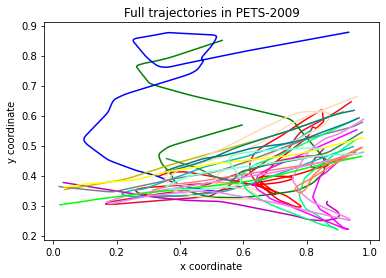

In [9]:
import random
color_names = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]

for i in range(len(data_p)):
    plt.plot(data_p[i][:,0],data_p[i][:,1],color=color_names[i])
plt.title("Full trajectories in PETS-2009") 
plt.xlabel("x coordinate")   
plt.ylabel("y coordinate") 
plt.show() 


## Splitting the data

In [10]:
def split_data_idgroups(combination,intervals_ids,data):
    # Form different combinations of training/testing sets
    training_set = []
    for i in range(len(combination)-1):
        for j in intervals_ids[combination[i]]:            
            training_set.append(data[j])
    testing_set = []
    for i in intervals_ids[combination[4]]:
        testing_set.append(data[i])    
    return training_set,testing_set

In [11]:
split_mode   = 1
total_length = len(data_p)

if split_mode==0:
    indices      = range(total_length)
    intervals_ids        = []
    # Pedestrians are split in groups of 4
    for i in range(0,total_length,4):
        intervals_ids.append(indices[i:i+4])

    # TODO: generalize?
    combinations=[(0,1,2,3,4),(0,1,2,4,3),(0,1,3,4,2),(0,2,3,4,1),(1,2,3,4,0)]
    # Generate train/test  
    train1,test1 = split_data_idgroups(combinations[0],intervals_ids,data_p)
    train2,test2 = split_data_idgroups(combinations[1],intervals_ids,data_p)
    train3,test3 = split_data_idgroups(combinations[2],intervals_ids,data_p)
    train4,test4 = split_data_idgroups(combinations[3],intervals_ids,data_p)
    train5,test5 = split_data_idgroups(combinations[4],intervals_ids,data_p)

elif split_mode==1:
    random.seed(0)
    indices      = arange(total_length)
    data_p = np.array(data_p)
    random.shuffle(indices)
    training_size = int(total_length * 0.80)
    testing_size  = total_length-training_size

    train1 = data_p[indices[0:training_size]]
    test1  = data_p[indices[training_size:]]

    print("[INF] Number of pedestrians "+str(total_length))
    print("[INF] Training with " ,len(train1))
    print("[INF] Testing with " ,len(test1))


[INF] Number of pedestrians 19
[INF] Training with  15
[INF] Testing with  4


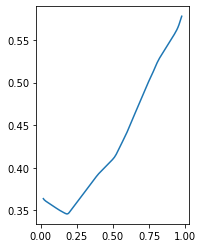

In [13]:
plt.subplot(121)
plt.plot(train1[0][:,0],train1[0][:,1])
if split_mode==0:
    plt.subplot(122)
    plt.plot(train5[0][:,0],train5[0][:,1])

In [14]:
length_obs         = 8
representation_mode= 'lineardev'

if representation_mode=='xy':
    trainX,trainY = split_sequence_training_xy(length_obs,train1)
if representation_mode=='dxdy':
    trainX,trainY = split_sequence_training_dxdy(length_obs,train1)    
if representation_mode=='lineardev':
    trainX,trainY = split_sequence_training_lineardev(length_obs,train1)        

In [15]:
trainX = np.reshape(trainX, (trainX.shape[0],trainX.shape[1],trainX.shape[2]))

In [16]:
data_shape = trainX.shape[1:]
print('[INF] Shape of training data ',np.shape(trainX))

[INF] Shape of training data  (3155, 8, 2)


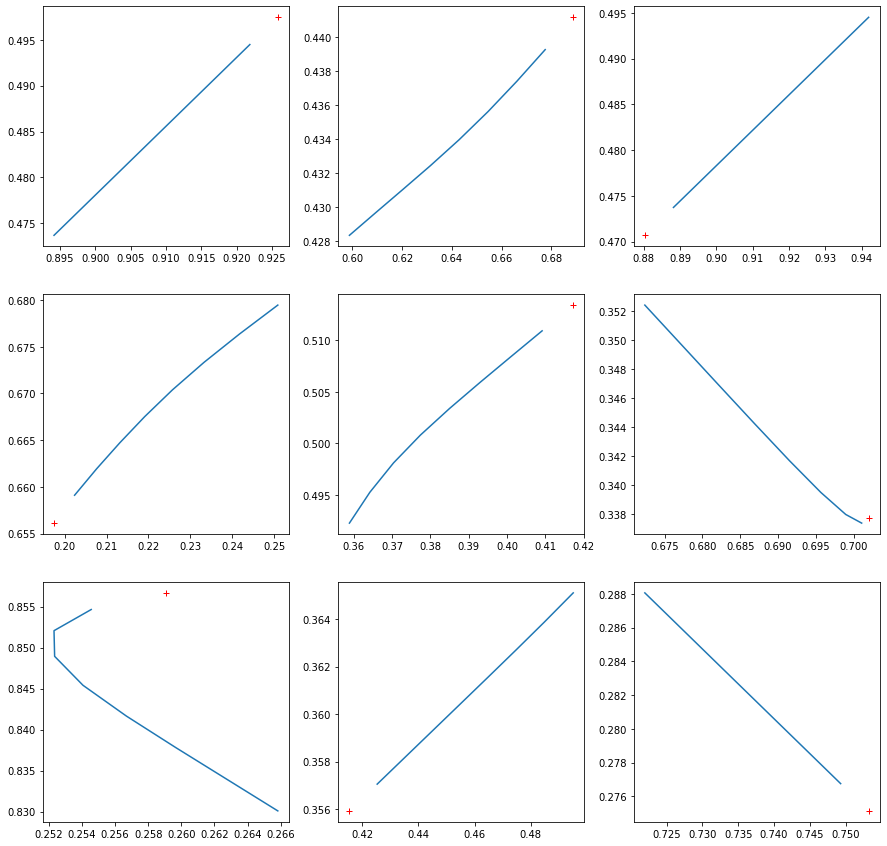

In [17]:
# Examples of training data
rnds = np.random.randint(0, np.shape(trainX)[0], size=9)
plt.subplots(3,3,figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,1+i)
    plt.plot(trainX[rnds[i]][:,0],trainX[rnds[i]][:,1])
    if representation_mode=='xy':
        plt.plot(trainY[rnds[i]][0],trainY[rnds[i]][1],'r+')
    if representation_mode=='dxdy':    
        plt.plot(trainX[rnds[i]][-1,0]+trainY[rnds[i]][0],trainX[rnds[i]][-1,1]+trainY[rnds[i]][1],'r+')
    if representation_mode=='lineardev':  
        x0,y0,vx,vy   = linear_lsq_model(trainX[rnds[i]][:,0],trainX[rnds[i]][:,1]) 
        x_pred_linear = x0+vx*(len(trainX[rnds[i]][:,0])+1)
        y_pred_linear = y0+vy*(len(trainX[rnds[i]][:,1])+1)
        plt.plot(x_pred_linear+trainY[rnds[i]][0],y_pred_linear+trainY[rnds[i]][1],'r+')
        

## Network

In [18]:
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras import initializers
from datetime import datetime
from keras.utils import plot_model

hidden_state = 10

if 'model' in globals(): del model
model = None
model = Sequential()
model.add(LSTM(hidden_state, return_sequences=True, input_shape=data_shape, name='lstm1'))
model.add(LSTM(hidden_state, name='lstm2'))
model.add(Dense(2))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm1 (LSTM)                 (None, 8, 10)             520       
_________________________________________________________________
lstm2 (LSTM)                 (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 22        
Total params: 1,382
Trainable params: 1,382
Non-trainable params: 0
_________________________________________________________________


In [20]:
#validation_data=(vali_obs, vali_pred),
opt = optimizers.RMSprop(lr = 0.01, decay=1e-2)
model.compile(optimizer=opt, loss='logcosh',metrics=['mse'])
# model.compile(optimizer=opt, loss='mean_squared_error',metrics=['mse'])
history= model.fit(trainX, trainY, epochs=250, batch_size=64, verbose=2)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/250





 - 1s - loss: 4.1981e-04 - mean_squared_error: 8.4486e-04
Epoch 2/250
 - 0s - loss: 3.5871e-05 - mean_squared_error: 7.1749e-05
Epoch 3/250
 - 0s - loss: 1.6699e-05 - mean_squared_error: 3.3402e-05
Epoch 4/250
 - 0s - loss: 1.1248e-05 - mean_squared_error: 2.2499e-05
Epoch 5/250
 - 0s - loss: 8.8091e-06 - mean_squared_error: 1.7621e-05
Epoch 6/250
 - 0s - loss: 8.2902e-06 - mean_squared_error: 1.6584e-05
Epoch 7/250
 - 0s - loss: 7.3937e-06 - mean_squared_error: 1.4789e-05
Epoch 8/250
 - 0s - loss: 7.2116e-06 - mean_squared_error: 1.4428e-05
Epoch 9/250
 - 0s - loss: 6.9666e-06 - mean_squared_error: 1.3937e-05
Epoch 10/250
 - 0s - loss: 6.6519e-06 - mean_squared_error: 1.3305e-05
Epoch 11/250
 - 0s - loss: 6.4890e-06 - mean_squared_error: 1.2980e-05
Epoch 12/250
 - 0s - loss: 6.2654e-06 - mean_squared_error: 1.2534e-05
Epoch 13/250
 - 0s - loss: 6.0302e-06 - mean_squared_

Epoch 79/250
 - 0s - loss: 1.9616e-06 - mean_squared_error: 3.9276e-06
Epoch 80/250
 - 0s - loss: 1.9810e-06 - mean_squared_error: 3.9643e-06
Epoch 81/250
 - 0s - loss: 1.9551e-06 - mean_squared_error: 3.9124e-06
Epoch 82/250
 - 0s - loss: 1.9559e-06 - mean_squared_error: 3.9142e-06
Epoch 83/250
 - 0s - loss: 1.9682e-06 - mean_squared_error: 3.9383e-06
Epoch 84/250
 - 0s - loss: 1.9522e-06 - mean_squared_error: 3.9066e-06
Epoch 85/250
 - 0s - loss: 1.9418e-06 - mean_squared_error: 3.8844e-06
Epoch 86/250
 - 0s - loss: 1.9668e-06 - mean_squared_error: 3.9351e-06
Epoch 87/250
 - 0s - loss: 1.9418e-06 - mean_squared_error: 3.8858e-06
Epoch 88/250
 - 0s - loss: 1.9579e-06 - mean_squared_error: 3.9176e-06
Epoch 89/250
 - 0s - loss: 1.9655e-06 - mean_squared_error: 3.9340e-06
Epoch 90/250
 - 0s - loss: 1.9535e-06 - mean_squared_error: 3.9092e-06
Epoch 91/250
 - 0s - loss: 1.9222e-06 - mean_squared_error: 3.8463e-06
Epoch 92/250
 - 0s - loss: 1.9460e-06 - mean_squared_error: 3.8943e-06
Epoch 

 - 0s - loss: 1.8359e-06 - mean_squared_error: 3.6742e-06
Epoch 194/250
 - 0s - loss: 1.8391e-06 - mean_squared_error: 3.6812e-06
Epoch 195/250
 - 0s - loss: 1.8402e-06 - mean_squared_error: 3.6820e-06
Epoch 196/250
 - 0s - loss: 1.8367e-06 - mean_squared_error: 3.6758e-06
Epoch 197/250
 - 0s - loss: 1.8377e-06 - mean_squared_error: 3.6778e-06
Epoch 198/250
 - 0s - loss: 1.8378e-06 - mean_squared_error: 3.6788e-06
Epoch 199/250
 - 0s - loss: 1.8417e-06 - mean_squared_error: 3.6858e-06
Epoch 200/250
 - 0s - loss: 1.8327e-06 - mean_squared_error: 3.6685e-06
Epoch 201/250
 - 0s - loss: 1.8388e-06 - mean_squared_error: 3.6778e-06
Epoch 202/250
 - 0s - loss: 1.8393e-06 - mean_squared_error: 3.6802e-06
Epoch 203/250
 - 0s - loss: 1.8385e-06 - mean_squared_error: 3.6778e-06
Epoch 204/250
 - 0s - loss: 1.8298e-06 - mean_squared_error: 3.6607e-06
Epoch 205/250
 - 0s - loss: 1.8351e-06 - mean_squared_error: 3.6731e-06
Epoch 206/250
 - 0s - loss: 1.8410e-06 - mean_squared_error: 3.6835e-06
Epoch 

In [21]:
history_dict= history.history
history_dict.keys()

dict_keys(['loss', 'mean_squared_error'])

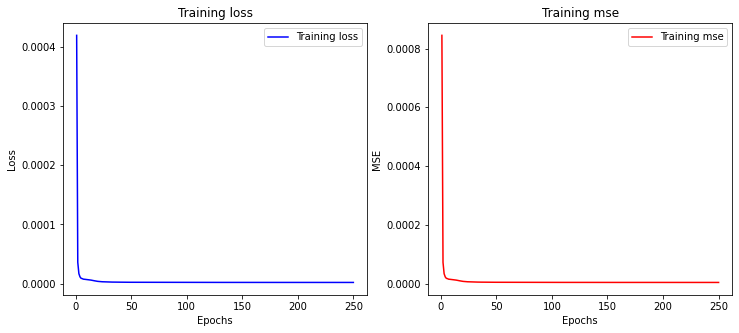

In [22]:
acc  = history.history['mean_squared_error']
loss = history.history['loss']
#val_acc = history.history['val_mean_squared_error']s
#val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, loss, 'b', label='Training loss')
#plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'r', label='Training mse')
#plt.plot(epochs, val_acc, 'g', label='Validation mse')
plt.title('Training mse')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

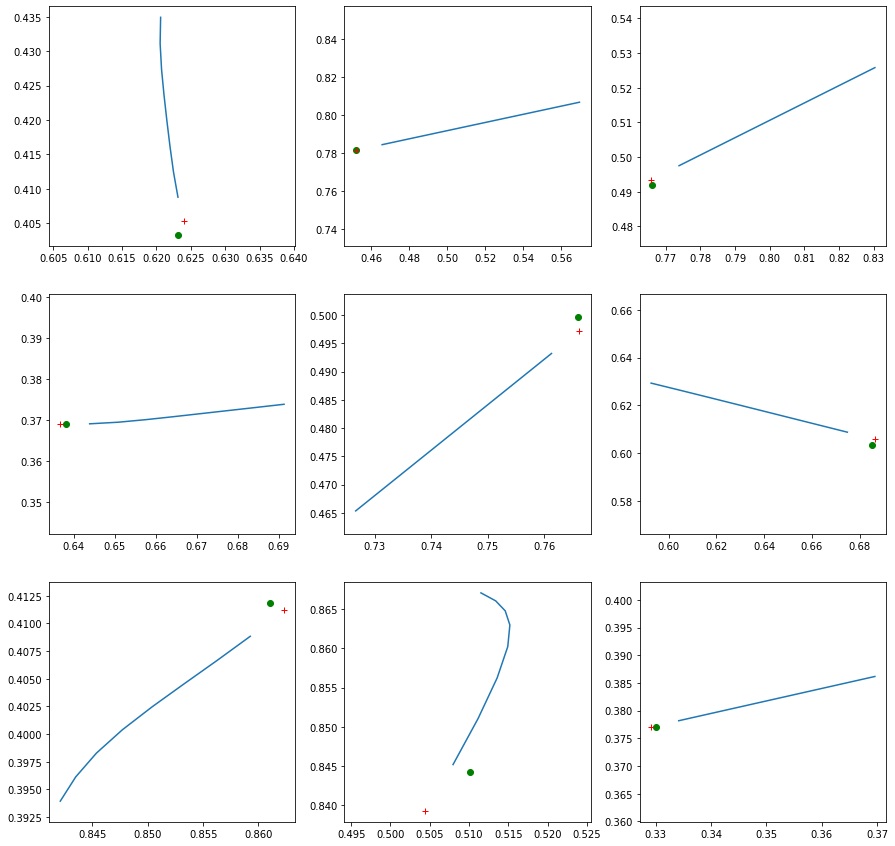

In [23]:
# Examples of training data
rnds = np.random.randint(0, np.shape(trainX)[0], size=9)
plt.subplots(3,3,figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,1+i)
    traj_obsr = np.reshape(trainX[rnds[i]], (1,trainX[rnds[i]].shape[0],trainX[rnds[i]].shape[1]) )
    # Applies the model to produce the next point
    next_point= model.predict(traj_obsr)
    plt.plot(trainX[rnds[i]][:,0],trainX[rnds[i]][:,1])
    if representation_mode=='xy':
        plt.plot(next_point[0][0],next_point[0][1],'go')        
        plt.plot(trainY[rnds[i]][0],trainY[rnds[i]][1],'r+')
    if representation_mode=='dxdy':    
        plt.plot(trainX[rnds[i]][-1,0]+next_point[0][0],trainX[rnds[i]][-1,1]+next_point[0][1],'go')
        plt.plot(trainX[rnds[i]][-1,0]+trainY[rnds[i]][0],trainX[rnds[i]][-1,1]+trainY[rnds[i]][1],'r+')
    if representation_mode=='lineardev':  
        x0,y0,vx,vy   = linear_lsq_model(trainX[rnds[i]][:,0],trainX[rnds[i]][:,1]) 
        x_pred_linear = x0+vx*(len(trainX[rnds[i]][:,0])+1)
        y_pred_linear = y0+vy*(len(trainX[rnds[i]][:,1])+1)
        plt.plot(x_pred_linear+next_point[0][0],y_pred_linear+next_point[0][1],'go')        
        plt.plot(x_pred_linear+trainY[rnds[i]][0],y_pred_linear+trainY[rnds[i]][1],'r+')
                
    plt.axis('equal')    

# Save the model

In [24]:
model.save('lstm-xy1.h5')

# Load the model

In [25]:
model = load_model('lstm-xy1.h5')

## Evaluate the errors

In [26]:
# Evaluate the ADE
def evaluate_ade(predicted_traj, true_traj, observed_length):
    
    error = np.zeros(len(true_traj) - observed_length)
    # For each point in the predicted trajectory
    for i in range(observed_length, len(true_traj)):
        # The predicted position
        pred_pos = predicted_traj[i]
        # The true position
        true_pos = true_traj[i]
        # The euclidean distance is the error
        error[i-observed_length] = np.linalg.norm(true_pos - pred_pos)

    # Return the mean error
    return np.mean(error)


In [27]:
# Evaluate the FDE
def evaluate_fde(predicted_traj, true_traj, observed_length):
    return np.linalg.norm(predicted_traj[-1]-true_traj[-1])

In [28]:
# This function takes a set of trajectories and build sub-sequences seq_length_obs+seq_length_pred
def split_sequence_testing(seq_length_obs,data,seq_length_pred): 
    tamano = int(len(data))
    X,Y_true = [],[]
    # se recorre todo los datos de test
    for j in range(tamano):
        traj = data[j]
        lon = traj.shape[0]-seq_length_obs-seq_length_pred
        for i in range(0,lon+1):
            a = traj[i:(i +seq_length_obs ), :]  
            X.append(a)
            # The full trajectory
            b = traj[i: (i+seq_length_obs+seq_length_pred), :]
            Y_true.append(b)
    return np.array(X),np.array(Y_true)

In [29]:
# Takes a testing set and evaluates errors on it
def evaluate_testing_set(datos, seq_length_obs, seq_length_pred,pixels=False, mode='xy'):
    # Observations and targets, by splitting the trajectories of the testing set
    X,Y_true  = split_sequence_testing(seq_length_obs,datos,seq_length_pred)
    total_ade = 0.0
    total_fde = 0.0
    # Iterate over the splitted testing data
    for i in range(len(X)):
        traj_obs  = X[i]
        traj_pred = X[i]
        # For each timestep to predict    
        for j in range(seq_length_pred):
            traj_obsr = np.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            # Applies the model to produce the next point
            next_point= model.predict(traj_obsr)
            if mode=='dxdy':
                next_point=next_point+traj_obs[-1]
            if mode=='lineardev':
                x0,y0,vx,vy   = linear_lsq_model(traj_obs[:,0],traj_obs[:,1]) 
                x_pred_linear = x0+vx*(len(traj_obs[:,0])+1)
                y_pred_linear = y0+vy*(len(traj_obs[:,1])+1)
                next_point=next_point+[x_pred_linear,y_pred_linear]    
            traj_obs  = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)
        # Evaluate the difference
        if pixels:
            traj_pred_pixels = np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
            traj_gt_pixels   = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
            total_ade += evaluate_ade(traj_pred_pixels, traj_gt_pixels, seq_length_obs)
            total_fde += evaluate_fde(traj_pred_pixels, traj_gt_pixels, seq_length_obs)
        else:
            total_ade += evaluate_ade(traj_pred, Y_true[i], seq_length_obs)
            total_fde += evaluate_fde(traj_pred, Y_true[i], seq_length_obs)

    error_ade = total_ade/len(X)
    error_fde = total_fde/len(X)
    if pixels:
        print('---------Error (pixels)--------')
    else:
        print('---------Error (normalized coordinates)--------')
    print('[RES] ADE: ',error_ade)
    print('[RES] FDE: ',error_fde)
        

In [30]:
evaluate_testing_set(test1,8,4,True,representation_mode)

---------Error (pixels)--------
[RES] ADE:  2.858728579101062
[RES] FDE:  4.428070266091001


## Quantitative evaluation

In [31]:
def split_sequence_start_testing(seq_length_obs,data,seq_length_pred):
    tamano = int(len(data))
    X,Y_true = [],[]
    for j in range(tamano):
        traj = data[j]
        X.append(traj[0:seq_length_obs,:])
        Y_true.append(traj[0:seq_length_obs+seq_length_pred,:])
    return np.array(X),np.array(Y_true)

In [32]:
def evaluate_testing_set_start(datos, seq_length_obs, seq_length_pred, mode='xy'):
    # Just the starting parts of the sequence
    X,Y_true    = split_sequence_start_testing(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    plt.figure(figsize=(18,15)) 
    color_names       = ["r","crimson" ,"g", "b","c","m","y","lightcoral", "peachpuff","grey","springgreen" ,"fuchsia","violet","teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    plt.subplot(1,1,1)
    print(len(X))
    # For all the subsequences
    for i in range(len(X)):
        traj_obs  = X[i]
        traj_pred = X[i]
        for j in range(seq_length_pred):
            # Observation reshaped to be fed to the model
            traj_obsr  = np.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            # Next position predicted
            next_point = model.predict(traj_obsr)
            if mode=='dxdy':
                next_point=next_point+traj_obs[-1]
            if mode=='lineardev':
                x0,y0,vx,vy   = linear_lsq_model(traj_obs[:,0],traj_obs[:,1]) 
                x_pred_linear = x0+vx*(len(traj_obs[:,0])+1)
                y_pred_linear = y0+vy*(len(traj_obs[:,1])+1)
                next_point=next_point+[x_pred_linear,y_pred_linear]      
            # Next observation will be shifted by one to the right
            traj_obs  = np.concatenate((traj_obs[1:len(traj_obs)],next_point),axis=0)
            traj_pred = np.concatenate((traj_pred,next_point),axis=0)

        error_ade = evaluate_ade(traj_pred,Y_true[i],seq_length_obs)
        error_fde = evaluate_fde(traj_pred,Y_true[i],seq_length_obs)                                     
        
        plt.plot(Y_true[i][0:8,0],Y_true[i][0:8,1],'*--',color=color_names[19-i],label = 'Observed')
        plt.plot(Y_true[i][7:,0],Y_true[i][7:,1],'--',color=color_names[i],label = 'GT')
        plt.plot(traj_pred[seq_length_obs-1:,0],traj_pred[seq_length_obs-1:,1],'-',color=color_names[19-i],label = 'Predicted')
        plt.axis('equal')
        total_error += error_ade
    plt.title("Predicting 4 positions with LTM-X-Y") 
    plt.xlabel('x-coordinate')
    plt.ylabel('y-coordinate')       
    error_model = total_error/len(X)
    print("[RES] Average error ",error_model)
    #plt.savefig("4predichas.pdf")
    plt.show()

19
[RES] Average error  0.005072411361581817


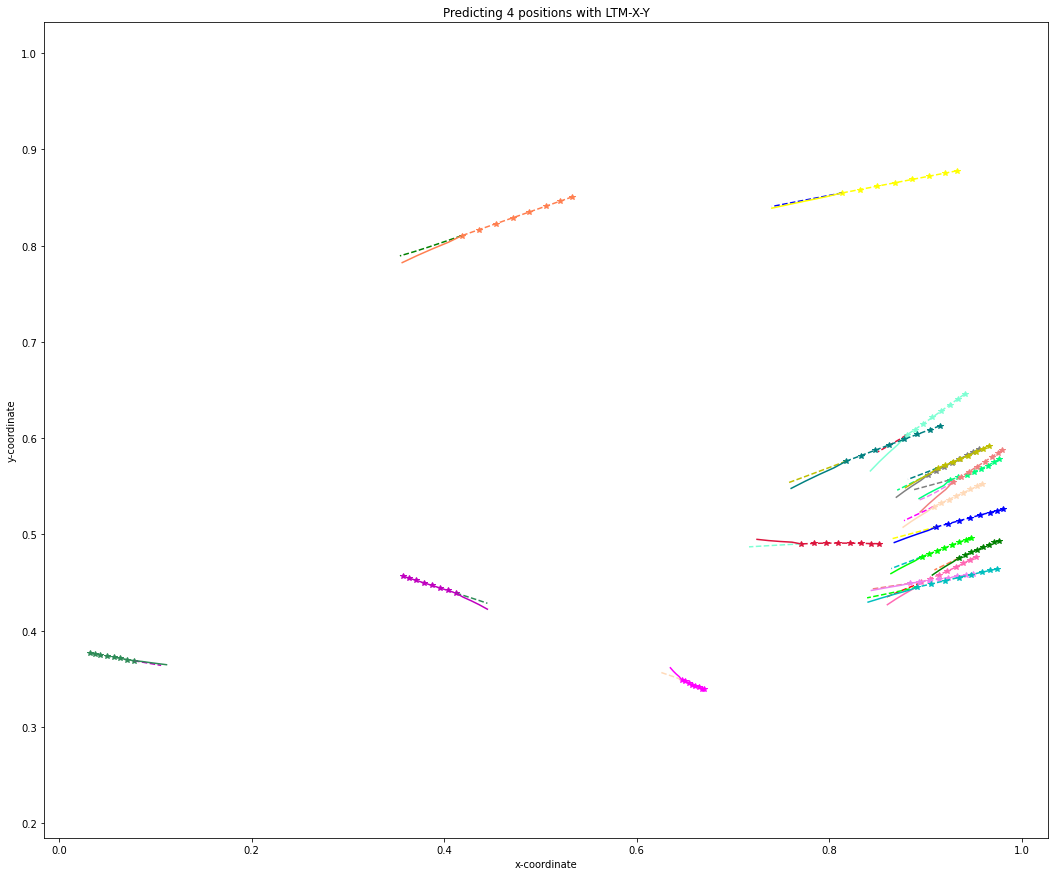

In [33]:
# Evaluate on the whole dataset
evaluate_testing_set_start(data_p,8,4,representation_mode)

## Qualitative evaluation

In [34]:
cruce = []
cruce.append(data_p[3][252:264,:])
cruce.append(data_p[4][135:147,:])

paralelos = []
paralelos.append(data_p[2][1:13])
paralelos.append(data_p[3][20:32])

inverso = []
inverso.append(data_p[4][167:179])
inverso.append(data_p[6][15:27])


In [35]:
def plot_qualitative(p,v,name):
    color_names = ["r", "g", "b","c","m","y", "peachpuff","grey", "fuchsia","violet",
                   "teal","seagreen","lime","yellow","coral","aquamarine","hotpink"]
    
    plot(p[0][0:8,0],p[0][0:8,1],'*--',color= color_names[2],label = 'Observed')
    plot(p[0][7:,0],p[0][7:,1],'-',color=color_names[2],label='Predicted')
    plot(v[0][7:,0],v[0][7:,1],'--',color=color_names[4],label='Ground truth')
    
    plot(p[1][0:8,0],p[1][0:8,1],'*--',color= color_names[2])
    plot(p[1][7:,0],p[1][7:,1],'-',color=color_names[2])
    plot(v[1][7:,0],v[1][7:,1],'--',color=color_names[4])
    
    plt.legend()
    plt.savefig(name)
    plt.show()

In [36]:
# Esta funcion hace la prediccion en coordenadas pixel
def sample_en_pixeles_cualitativamente(datos, seq_length_obs, seq_length_pred, mode='xy'):
    
    
    X,Y_true = split_sequence_testing(seq_length_obs,datos,seq_length_pred)
    total_error = 0.0
    total_final = 0.0
    trayectoria = []
    verdadero= []
    
    for i in range(len(X)):
        traj_obs = X[i]
        traj_pred = X[i]
        
        for j in range(seq_length_pred):
            traj_obsr  = np.reshape(traj_obs, (1,traj_obs.shape[0],traj_obs.shape[1]) )
            # Applies the model
            next_point = model.predict(traj_obsr)
            if mode=='dxdy':
                next_point=next_point+traj_obs[-1]
            if mode=='lineardev':
                x0,y0,vx,vy   = linear_lsq_model(traj_obs[:,0],traj_obs[:,1]) 
                x_pred_linear = x0+vx*(len(traj_obs[:,0])+1)
                y_pred_linear = y0+vy*(len(traj_obs[:,1])+1)
                next_point=next_point+[x_pred_linear,y_pred_linear]          
            traj_obs   = np.concatenate((traj_obs[1:len(traj_obs)], next_point), axis = 0)
            traj_pred  = np.concatenate((traj_pred, next_point), axis = 0)
        
        traj_pre =  np.column_stack((768*traj_pred[:,0],576*traj_pred[:,1]))
        traj_tr = np.column_stack((768*Y_true[i][:,0],576*Y_true[i][:,1]))
       
        trayectoria.append(traj_pre)
        verdadero.append(traj_tr)
        #SE CALCULA LA METRICA ADE 
        
        total_error += evaluate_ade(traj_pre, traj_tr, seq_length_obs)
        total_final += evaluate_fde(traj_pre, traj_tr, seq_length_obs)
            
    error_modelo     = total_error/len(X)
    error_fde_modelo = total_final/len(X)
        
    print('---------Error--------')
    print('ADE')
    print(error_modelo)
    print('FDE')
    print(error_fde_modelo)
    return trayectoria, verdadero

---------Error--------
ADE
1.3053014298826353
FDE
2.1588863905377775


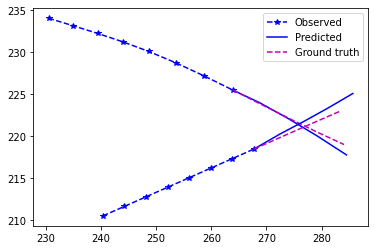

In [37]:
"""
Para graficar los resultados cualitativos se escoge el mejor modelo de los 
5,  para pets con framerate 7.5
"""
band = 0
if(band==0):
    p,v = sample_en_pixeles_cualitativamente(cruce,8,4,representation_mode)
    name = "cruce_absoluto_ing.pdf"
elif(band==1):
    p,v = sample_en_pixeles_cualitativamente(paralelos,8,4,representation_mode)
    name = "paralelos_absoluto_ing.pdf"
else:
    p,v = sample_en_pixeles_cualitativamente(inverso,8,4,representation_mode)
    name = "inverso_absoluto_ing.pdf"
plot_qualitative(p,v,name)